# GENIA post-hoc prediction refinement
In this notebook, we'll dig further into the idea that GENIA's semantic breadth is responsible for its decreased performance on the PICKLE corpus. We'll do this by removing predictions that fall outside the boundary of the PICKLE unique words semantic cluster.

In [81]:
from gensim.models import KeyedVectors
import jsonlines
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
plt.rcParams.update({'font.size': 14})
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# Importing my own Dataset class
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset

## Reading in the data
We need two things for this analysis: the word vectors for each model, and the predictions on PICKLE by the GENIA model. We'll use the same code from the `corpus_semantic_syntactic_analysis.ipynb` notebook to read in and separate the word vectors.

### Word vectors

In [2]:
# Import the word vectors
word2vecs = '../data/straying_off_topic_data/corpus_comparison/pickle_scierc_genia_combined_word2vec_skipgram.wordvectors'
vecs = KeyedVectors.load(word2vecs)

In [3]:
# Import the datasets
def read_dataset(path, name):
    """
    Read in a dataset to a Dataset object.
    """
    objs = []
    with jsonlines.open(path) as reader:
        for obj in reader:
            objs.append(obj)
            
    dset = Dataset(name, objs)
    
    return dset

In [4]:
scierc_path = '../../dygiepp/data/scierc/processed_data/json/train.json'
genia_path = '../../dygiepp/data/genia/processed-data/json-coref-ident-only/train.json'
pickle_path = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/FINAL_ENTITIES_all_gold_standard_abstracts_GOLD_STD_03Mar2022.jsonl'

scierc = read_dataset(scierc_path, 'SciERC')
genia = read_dataset(genia_path, 'GENIA')
pickle = read_dataset(pickle_path, 'PICKLE')

In [5]:
# Sort vectors
# Heads up that this is slow
sep_vecs = {}
for dset in [scierc, genia, pickle]:
    _ = dset.get_dataset_vocab()
    dset_comb_vocab = list(dset.vocab['unigrams']) + list(dset.vocab['bigrams']) + list(dset.vocab['trigrams'])
    dset_vecs = {k:vecs[k] for k in vecs.index_to_key if k in dset_comb_vocab}
    sep_vecs[dset.get_dataset_name()] = dset_vecs

### GENIA predictions

In [6]:
with jsonlines.open('../data/straying_off_topic_data/model_output/dygiepp/FINAL_PERF_08Nov2022/model_predictions/FINAL_perf_10Nov2022_formatted_data_genia_predictions.jsonl') as reader:
    genia_preds = []
    for obj in reader:
        genia_preds.append(obj)
with jsonlines.open('../data/straying_off_topic_data/model_output/dygiepp/FINAL_PERF_08Nov2022/model_predictions/FINAL_perf_10Nov2022_formatted_data_genia-lightweight_predictions.jsonl') as reader:
    genia_lightpreds = []
    for obj in reader:
        genia_preds.append(obj)

## Defining the cutoff boundary
We need an empirical way to determine which predictions to exclude based on semantic distance from the PICKLE vectors. We can do this by using PICKLE as a cluster, and finding its cluster center. We can then use the farthest-away PICKLE points to define the maximum distance that a point is allowed to be from the center in order to be considered a valid prediction. We can tune the forgiveness of that distance (e.g. can allow some margin of error in addition to the maximum PICKLE distance to make the maximum includion distance be somewhat larger) as if it were a hyperparameter, to see where we get the best performance of the GENIA model.

### Getting the centroid of the PICKLE cluster
We can do this by taking the average of all the points. Since this is a dataset in more than two dimensions, we'll take advantage of the [numpy builtin methods](https://stackoverflow.com/a/65908474).

In [7]:
pickle_arr = np.asarray([v for k,v in sep_vecs['PICKLE'].items()])
pickle_centroid = pickle_arr.mean(axis=0)

### Defining the max distance from the centroid
The tricky part here is that the cluster is not symmetric. So we have to decide -- do we want to create a symmetric boundary using the max distance? Or will that include too many miscellaneous points? Let's do a few visualizations with the PCA reduction of the PICKLE cluster to get some intuition for what different boundary options will look like.

In [40]:
# Fit on all the vectors, then transform each individually to keep the sorted structure

# Make input array
X = []
for k in vecs.index_to_key:
    X.append(vecs[k])

# Fit PCA
pca = PCA(n_components=2)
pca.fit(X)

# Transform the vectors
x, y, group = [], [], []
for dset in sep_vecs:
    for word in sep_vecs[dset]:
        word_vec = sep_vecs[dset][word].reshape(1, -1)
        transformed = pca.transform(word_vec).flatten()
        x.append(transformed[0])
        y.append(transformed[1])
        group.append(dset)

Text(0, 0.5, 'PC2')

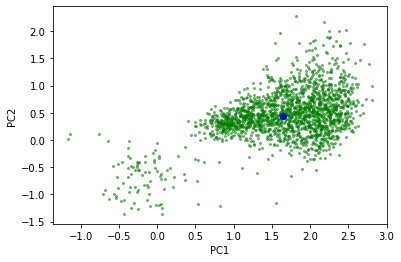

In [41]:
# Separate out the PICKLE vecs
pick_x, pick_y = [], []
for i, g in enumerate(group):
    if g == 'PICKLE':
        pick_x.append(x[i])
        pick_y.append(y[i])

# Specifically transform the centroid calculated above
pick_c_x, pick_c_y = pca.transform(pickle_centroid.reshape(1, -1)).flatten()

# Plot
scatter = plt.scatter(x=pick_x, y=pick_y, color='green', alpha = 0.5, s=4)
plt.plot(pick_c_x, pick_c_y, color='blue', marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')

The full-dimensional radius is 4.5268354415893555, which is different from the 2D radius of 2.8411894895403926. Using the transformed point distance radius for the plot below.


Text(0, 0.5, 'PC2')

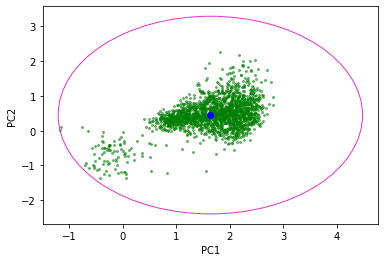

In [46]:
# Define symmetric boundary, add as a circle to the plot
dists = euclidean_distances(pickle_centroid.reshape(1, -1), pickle_arr).flatten()
radius = dists.max()
pca_dists = euclidean_distances(np.asarray([pick_c_x, pick_c_y]).reshape(1, -1), np.column_stack([pick_x, pick_y]))
pca_radius = pca_dists.max()
print(f'The full-dimensional radius is {radius}, which is different from the 2D radius '
     f'of {pca_radius}. Using the transformed point distance radius for the plot below.')

scatter = plt.scatter(x=pick_x, y=pick_y, color='green', alpha = 0.5, s=4)
plt.plot(pick_c_x, pick_c_y, color='blue', marker='o')
ax = plt.gca()
symm_bound = plt.Circle((pick_c_x, pick_c_y), pca_radius, edgecolor=(0.9,0.2,0.8,1), facecolor=(1, 0, 0, 0))
ax.add_patch(symm_bound)
plt.xlabel('PC1')
plt.ylabel('PC2')


The symmetric boundary is clearly non-ideal, as it includes a lot of space where there are no PICKLE points. What if we define an ellipse instead? This leads to two questions: (1) How do we determine the semi-major and semi-minor axes? and (2) Do we need to change the angle that the ellipse sits in space? 
<br><br>

Let's try the followiong algorithm:
* Take the distance between the "top" (highest y value) and "bottom" (lowest y value) points to get the semi-minor axis
* Do this for the x direction to get a better semi-major axis length than just the max distance x2
* Use the midpoint between all 4 points as the center, as opposed to the centroid

In [50]:
# Redefining the ellipse with min and max x and y values
pick_x_arr = np.asarray(pick_x)
pick_y_arr = np.asarray(pick_y)
max_y_val = pick_y_arr.max()
min_y_val = pick_y_arr.min()
max_x_val = pick_x_arr.max()
min_x_val = pick_x_arr.min()

In [52]:
major_len = max_x_val - min_x_val
minor_len = max_y_val - min_y_val
center_x = min_x_val + major_len/2
center_y = min_y_val + minor_len/2

Text(0, 0.5, 'PC2')

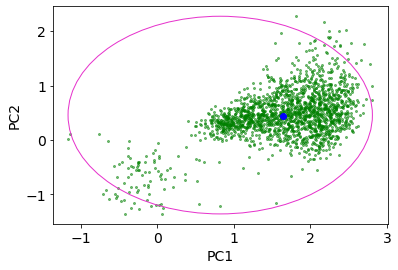

In [56]:
# Add elliptical boundary to the plot
scatter = plt.scatter(x=pick_x, y=pick_y, color='green', alpha = 0.5, s=4)
plt.plot(pick_c_x, pick_c_y, color='blue', marker='o')
ax = plt.gca()
ell_bound = Ellipse((center_x, center_y), major_len, minor_len, edgecolor=(0.9,0.2,0.8,1), facecolor=(1, 0, 0, 0))
ax.add_patch(ell_bound)
plt.xlabel('PC1')
plt.ylabel('PC2')

This is clearly much better, but we'd still like, if not all, at least most of the points to be inside of the ellipse. Can we achieve this by rotating the ellipse? The other question that comes here is, how does this translate into multiple dimensions? We could also just do the entire analysis on the PCA-reduced dataset, but it seems nice to be able to translate this to n-dimensions. But before we deal with that, let's find a boundary we're happy with in 2D.

To get the angle of the ellipse without guess-and-checking, let's fit a regression line for this scatter plot, and use the angle of that line to the X-axis to define the angle of the ellipse. 

In [77]:
# Fit the regression
reg = LinearRegression()
reg.fit(pick_x_arr.reshape(-1, 1), pick_y)

LinearRegression()

Text(0, 0.5, 'PC2')

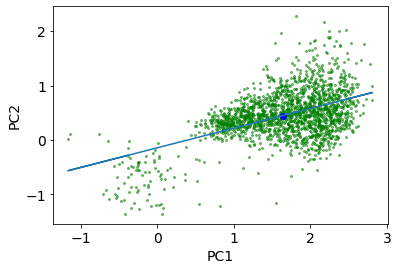

In [78]:
# Plot the line to visualize
scatter = plt.scatter(x=pick_x, y=pick_y, color='green', alpha = 0.5, s=4)
plt.plot(pick_c_x, pick_c_y, color='blue', marker='o')
plt.plot(pick_x, reg.predict(pick_x_arr.reshape(-1,1)))
plt.xlabel('PC1')
plt.ylabel('PC2')

In [83]:
# Calculate the angle
# First, choose a point somewhere on the line
apoint_x = pick_x[10]
apoint_y = reg.predict(np.asarray(apoint_x).reshape(-1,1))
print(f'The point we\'re using for this calculation is {(apoint_x, apoint_y)}')

# Then, get the intercept of the line
intercept = reg.predict(np.asarray(0).reshape(-1,1))
print(f'The intercept of the line is: {intercept[0]}')

# Then use the formula: arctan((y - intercept)/x) to get the angle!
angle = math.atan((apoint_y - intercept)/apoint_x)
angle = math.degrees(angle)
print(f'The angle of the line is: {angle}')

The point we're using for this calculation is (2.338522666087761, array([0.70202625]))
The intercept of the line is: -0.14235530569540655
The angle of the line is: 19.853372790985407


Now that we have an angle, let's try our ellipse again:

Text(0, 0.5, 'PC2')

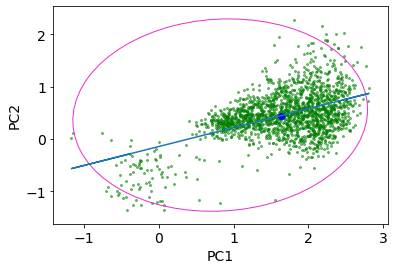

In [87]:
# Add elliptical boundary to the plot
scatter = plt.scatter(x=pick_x, y=pick_y, color='green', alpha = 0.5, s=4)
plt.plot(pick_c_x, pick_c_y, color='blue', marker='o')
plt.plot(pick_x, reg.predict(pick_x_arr.reshape(-1,1)))
ax = plt.gca()
ell_bound = Ellipse((center_x, center_y), major_len, minor_len, angle=angle, edgecolor=(0.9,0.2,0.8,1), facecolor=(1, 0, 0, 0))
ax.add_patch(ell_bound)
plt.xlabel('PC1')
plt.ylabel('PC2')